Team: Aleksandr Alekseevich, Aleksandr Semiletov, Aleksandr Mizgirev<br>
Dataset: https://www.kaggle.com/conorrot/irish-weather-hourly-data<br>

You can find the difinition for all columns here: https://pastebin.com/x6ZC2mGG

Step 1. I choose these columns for the first lab:

temp - Air Temperature °C<br>
vappr - Wet Bulb Air Temperature hpa<br>
dewpt - Dew Point Air Temperature °C<br>
msl - Mean Sea Level Pressure hPa<br>


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy
import seaborn as sns
from scipy.optimize import least_squares

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

In [2]:
path_to_file = 'C:/Users/aleks/Downloads/hrly_Irish_weather.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.head()

   county  station  latitude  longitude               date rain  temp  wetb  \
0  Galway  ATHENRY    53.289     -8.786  26-jun-2011 01:00  0.0  15.3  14.5   
1  Galway  ATHENRY    53.289     -8.786  26-jun-2011 02:00  0.0  14.7  13.7   
2  Galway  ATHENRY    53.289     -8.786  26-jun-2011 03:00  0.0  14.3  13.4   
3  Galway  ATHENRY    53.289     -8.786  26-jun-2011 04:00  0.0  14.4  13.6   
4  Galway  ATHENRY    53.289     -8.786  26-jun-2011 05:00  0.0  14.4  13.5   

  dewpt vappr rhum     msl wdsp wddir  sun  vis clht clamt  
0  13.9  15.8   90  1016.0    8   190  NaN  NaN  NaN   NaN  
1  12.9  14.9   89  1015.8    7   190  NaN  NaN  NaN   NaN  
2  12.6  14.6   89  1015.5    6   190  NaN  NaN  NaN   NaN  
3  12.8  14.8   90  1015.3    7   180  NaN  NaN  NaN   NaN  
4  12.7  14.7   89  1015.1    6   190  NaN  NaN  NaN   NaN  

In [3]:
# Filter empty strings

source_df = source_df[['temp','vappr','dewpt','msl']]

source_df = source_df[source_df['temp'] != ' ']
source_df = source_df[source_df['vappr'] != ' ']
source_df = source_df[source_df['dewpt'] != ' ']
source_df = source_df[source_df['msl'] != ' ']

source_df = source_df[source_df['temp'].isnull() != True]
source_df = source_df[source_df['vappr'].isnull() != True]
source_df = source_df[source_df['dewpt'].isnull() != True]
source_df = source_df[source_df['msl'].isnull() != True]


temp = source_df['temp']
temp = temp.apply(lambda x: float(x))

vappr = source_df['vappr']
vappr = vappr.apply(lambda x: float(x))

dewpt = source_df['dewpt']
dewpt = dewpt.apply(lambda x: float(x))

msl = source_df['msl']
msl = msl.apply(lambda x: float(x))

Step 2. Plotting a non-parametric estimation of PDF in form of a histogram and using
kernel density function (or probability law in case of discrete RV)

<AxesSubplot:xlabel='msl', ylabel='Count'>

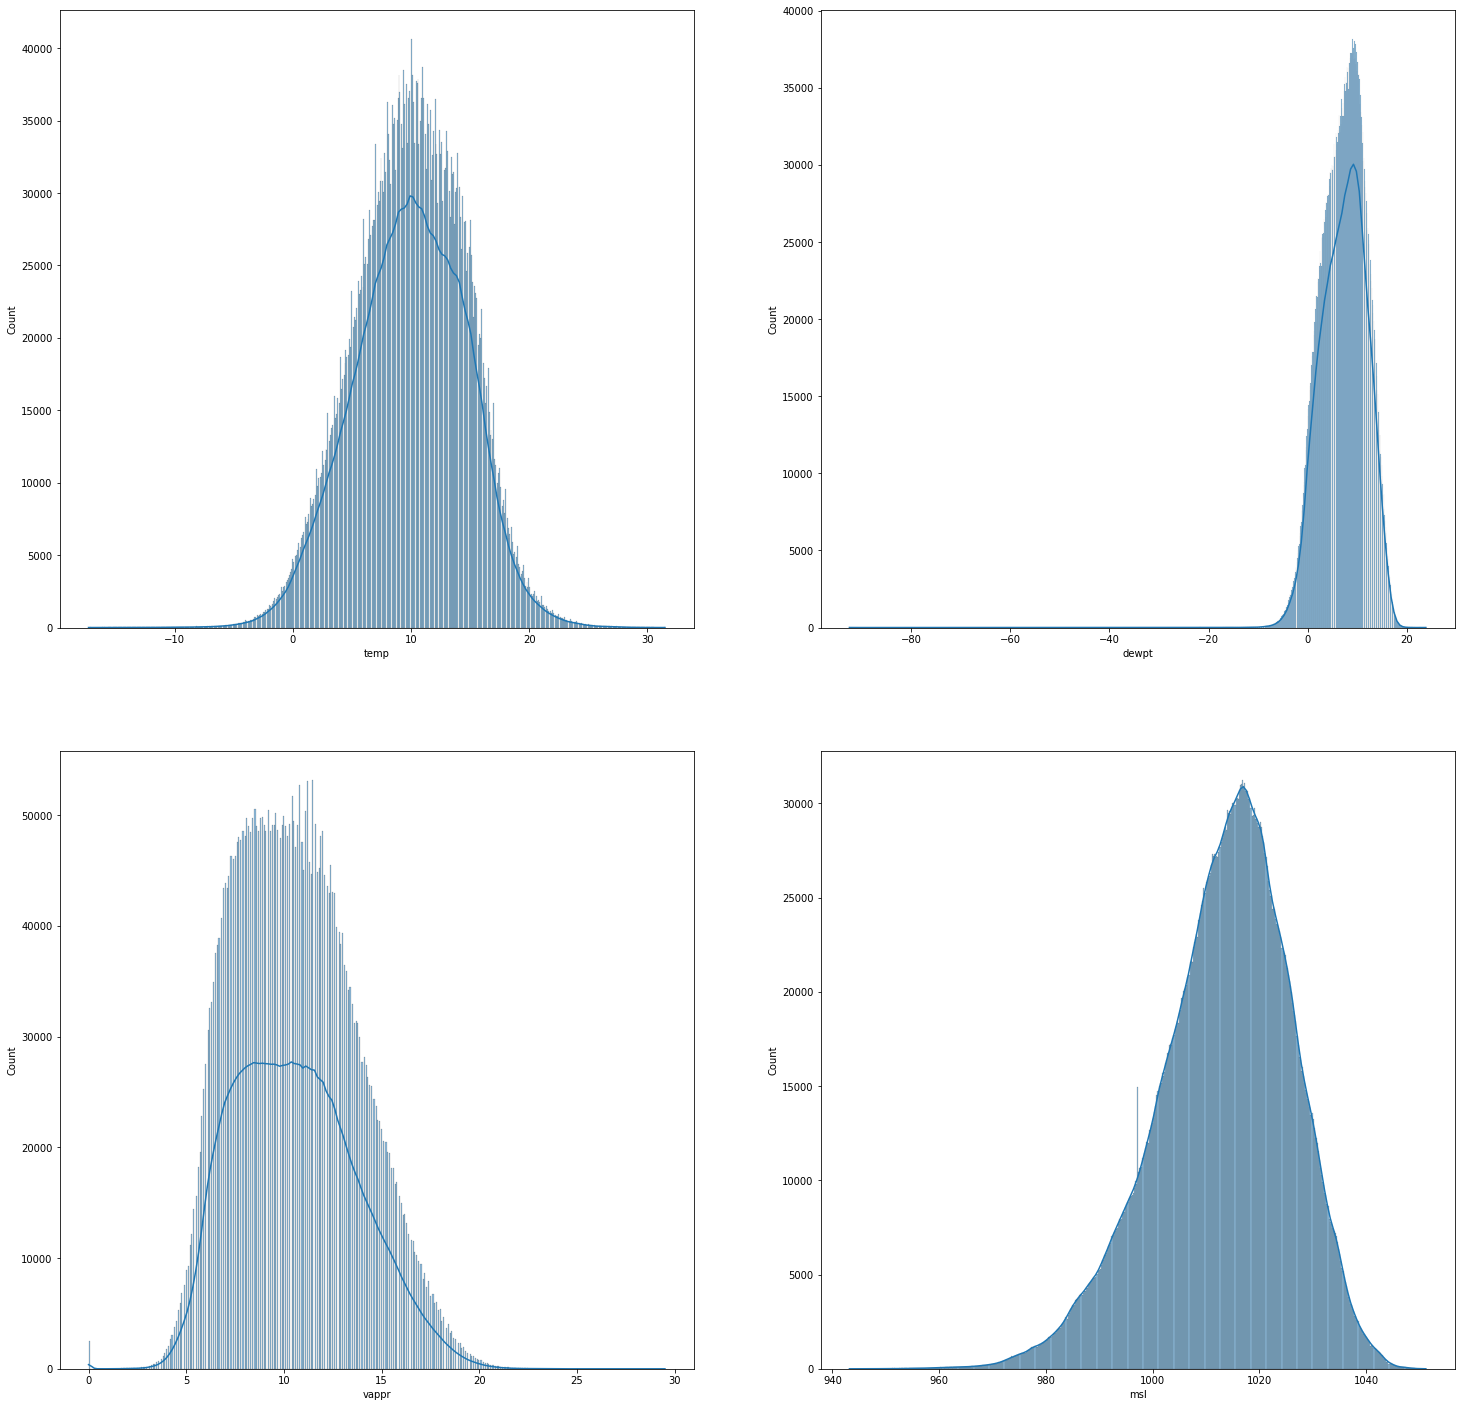

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))
sns.histplot(temp, ax=axes[0, 0], kde=True )
sns.histplot(vappr, ax=axes[1, 0], kde=True )
sns.histplot(dewpt, ax=axes[0, 1], kde=True )
sns.histplot(msl, ax=axes[1, 1], kde=True )

Step 3. We make an estimation of order statistics and represent them as “box with whiskers” plot.<br>

Explanation:
- The mean is the red dashed line.
- The median is the Black line.
- The first quartile is the left edge of the rectangle.
- The third quartile is the right edge of the rectangle.
- The interquartile range is the length of the rectangle.
- The range contains everything from left to right.
- The outliers are the dots to the left and right.

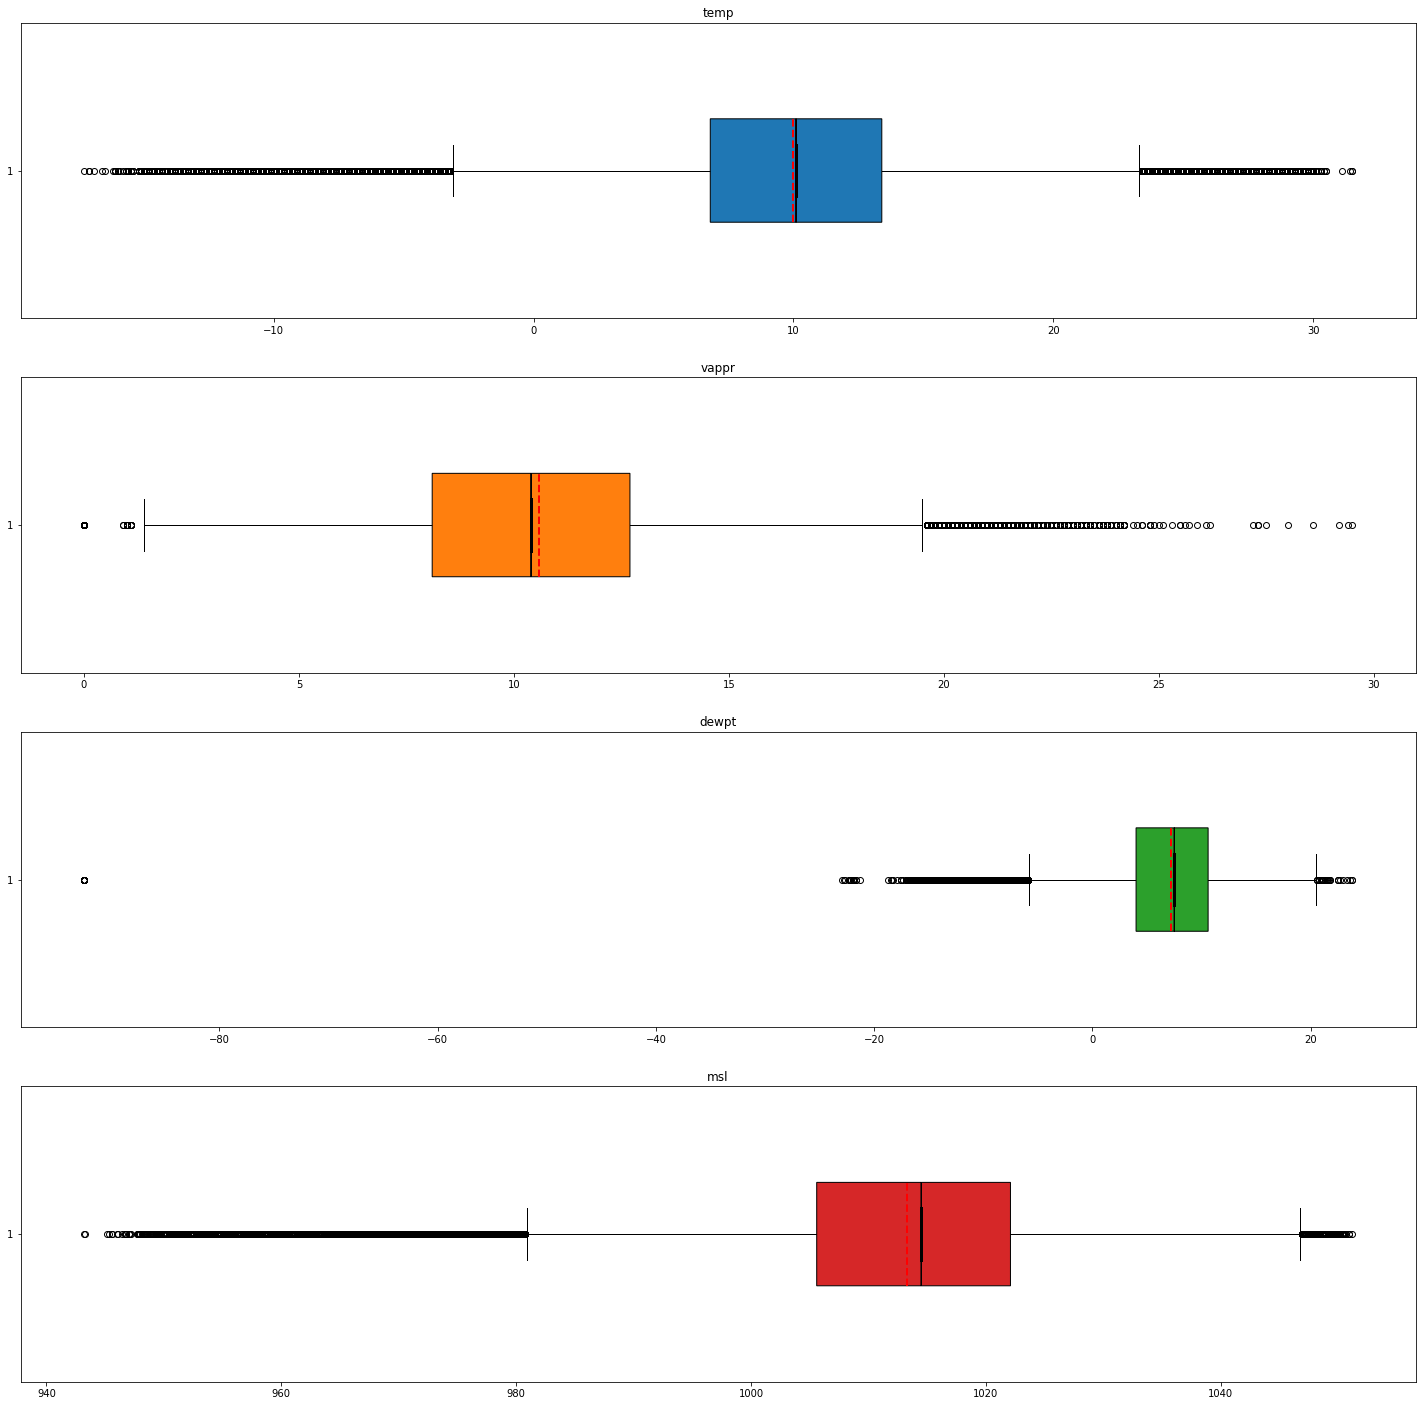

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 25))

axes[0].boxplot((temp), vert=False, notch=True, widths=0.35,
           showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 3, 'color': 'black'},
           meanprops={'linewidth': 2, 'color': 'red'}
                ,boxprops=dict(facecolor="C0"))
axes[0].set_title('temp')

axes[1].boxplot((vappr), vert=False, notch=True, widths=0.35,
           showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 3, 'color': 'black'},
           meanprops={'linewidth': 2, 'color': 'red'}
                ,boxprops=dict(facecolor="C1"))
axes[1].set_title('vappr')

axes[2].boxplot((dewpt), vert=False, notch=True, widths=0.35,
           showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 3, 'color': 'black'},
           meanprops={'linewidth': 2, 'color': 'red'}
                ,boxprops=dict(facecolor="C2"))
axes[2].set_title('dewpt')

axes[3].boxplot((msl), vert=False, notch=True, widths=0.35,
           showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 3, 'color': 'black'},
           meanprops={'linewidth': 2, 'color': 'red'}
                ,boxprops=dict(facecolor="C3"))
axes[3].set_title('msl')

plt.show()

Step 4. We think that all these columns correspond to the normal distribution

Step 5. Estimate parameters of chosen distributions using methods of maximum likelihood
and least squares method.

In [6]:
mle_temp = sts.norm.fit(temp)
mle_vappr = sts.norm.fit(vappr)
mle_dewpt = sts.norm.fit(dewpt)
mle_msl = sts.norm.fit(msl)

def least_squares_temp(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(temp, q)
    quantiles_approx = scipy.stats.norm.ppf(q, *params)
    return quantiles - quantiles_approx
def least_squares_vappr(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(vappr, q)
    quantiles_approx = scipy.stats.norm.ppf(q, *params)
    return quantiles - quantiles_approx
def least_squares_dewpt(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(dewpt, q)
    quantiles_approx = scipy.stats.norm.ppf(q, *params)
    return quantiles - quantiles_approx
def least_squares_msl(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(msl, q)
    quantiles_approx = scipy.stats.norm.ppf(q, *params)
    return quantiles - quantiles_approx

ls_temp = least_squares(least_squares_temp, (1.0, 1.0))['x']
ls_vappr = least_squares(least_squares_vappr, (1.0, 1.0))['x']
ls_dewpt = least_squares(least_squares_dewpt, (1.0, 1.0))['x']
ls_msl = least_squares(least_squares_msl, (1000.0, 10))['x']


print(f"ml temp {mle_temp}")
print(f"ml vappr {mle_vappr}")
print(f"ml dewpt {mle_dewpt}")
print(f"ml msl {mle_msl}")
print(f"ls temp {ls_temp}")
print(f"ls vappr {ls_vappr}")
print(f"ls dewpt {ls_dewpt}")
print(f"ls msl {ls_msl}")

ml temp (9.99195449792312, 4.695992084968425)
ml vappr (10.58677030758707, 3.152974324797822)
ml dewpt (7.230309188564742, 4.47278497534584)
ml msl (1013.2813786209779, 12.587859921089885)
ls temp [10.01699761  4.72713084]
ls vappr [10.56308993  3.10286926]
ls dewpt [7.29633132 4.60504548]
ls msl [1013.4871528    12.90128237]


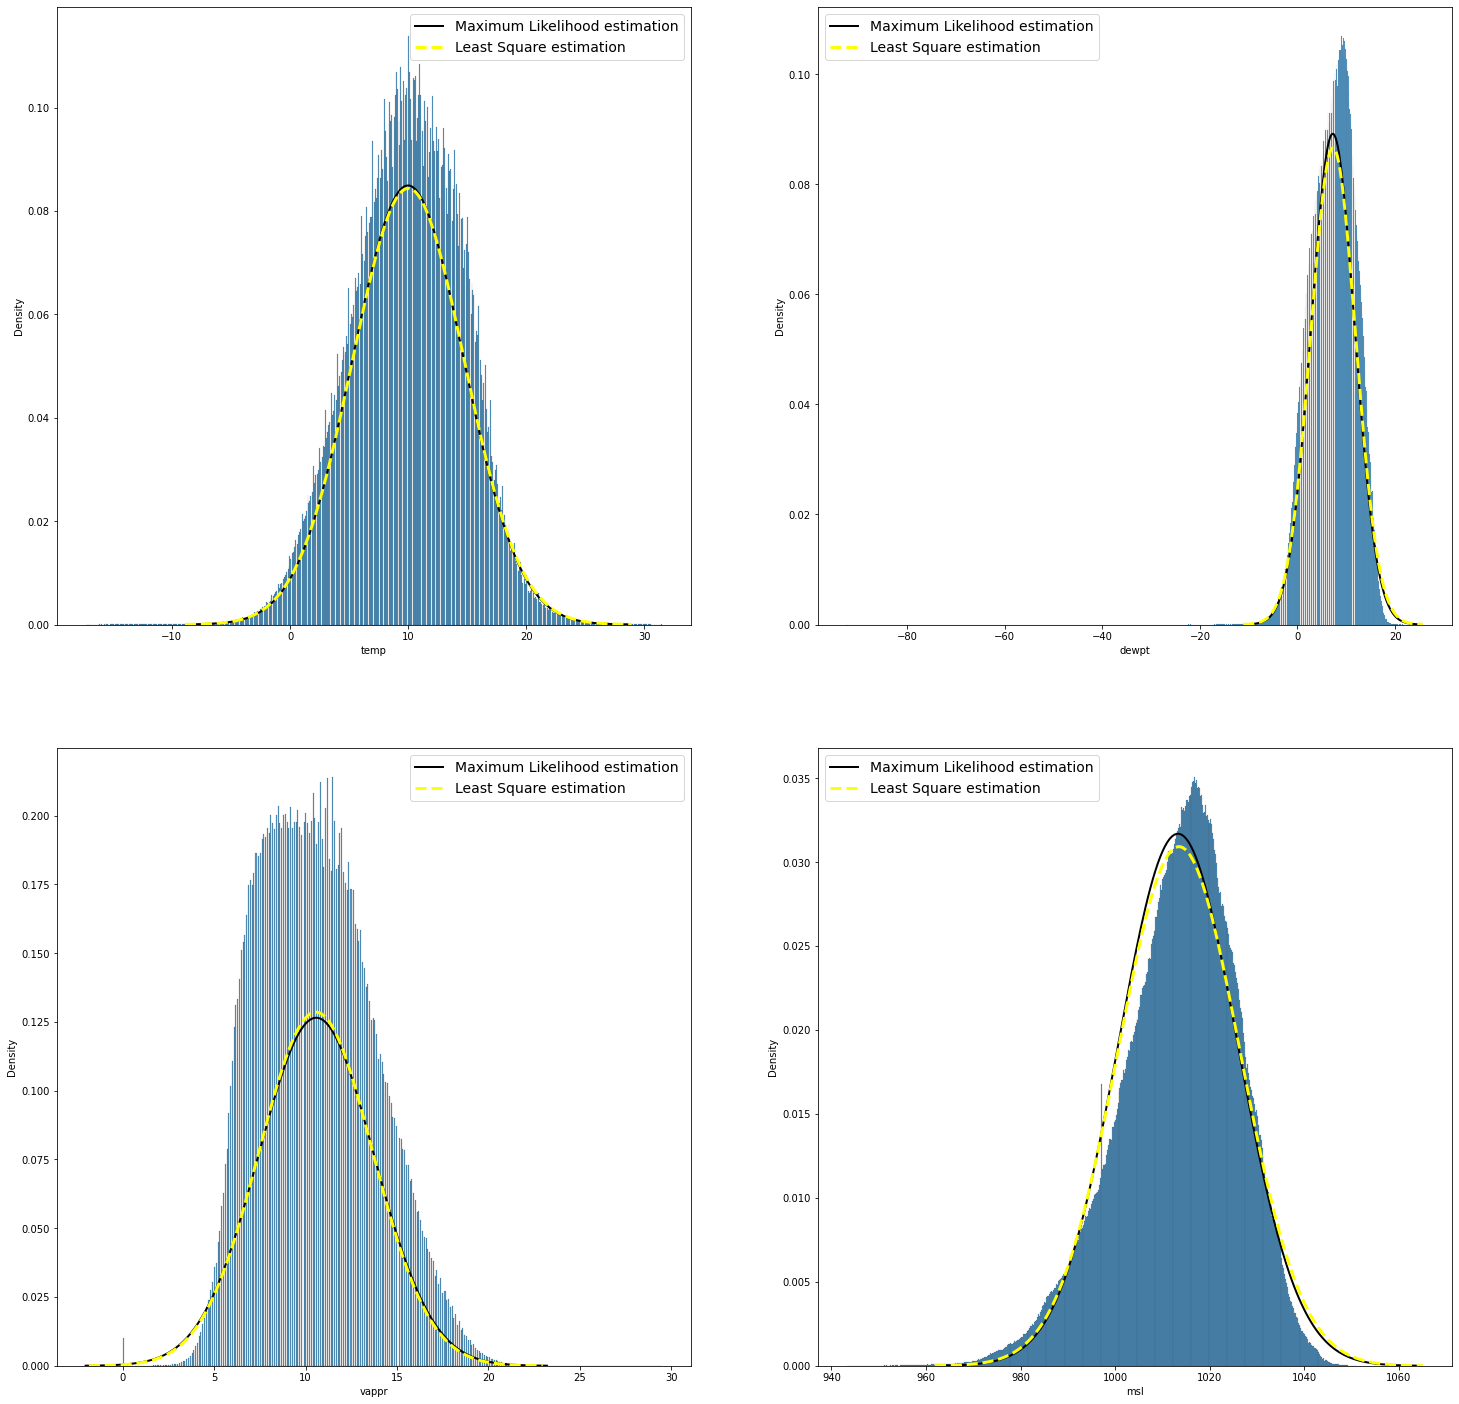

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))

def normal(mean, std, ax, dashed=False, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = scipy.stats.norm.pdf(x, mean, std)
    if dashed:
        z = ax.plot(x, p, "yellow", linestyle='dashed', linewidth=3)
    else:
        z = ax.plot(x, p, color, linewidth=2)

ax = sns.histplot(x=temp, stat="density", ax=axes[0, 0])
normal(mle_temp[0], mle_temp[1], axes[0, 0])
normal(ls_temp[0], ls_temp[1], axes[0, 0], dashed=True)
axes[0, 0].legend(["Maximum Likelihood estimation", "Least Square estimation"], prop={"size": 14})

ax = sns.histplot(x=vappr, stat="density", ax=axes[1, 0])
normal(mle_vappr[0], mle_vappr[1], axes[1, 0])
normal(ls_vappr[0], ls_vappr[1], axes[1, 0], dashed=True)
axes[1, 0].legend(["Maximum Likelihood estimation", "Least Square estimation"], prop={"size": 14})

ax = sns.histplot(x=dewpt, stat="density", ax=axes[0, 1])
normal(mle_dewpt[0], mle_dewpt[1], axes[0, 1])
normal(ls_dewpt[0], ls_dewpt[1], axes[0, 1], dashed=True)
axes[0, 1].legend(["Maximum Likelihood estimation", "Least Square estimation"], prop={"size": 14})

ax = sns.histplot(x=msl, stat="density", ax=axes[1, 1])
normal(mle_msl[0], mle_msl[1], axes[1, 1])
normal(ls_msl[0], ls_msl[1], axes[1, 1], dashed=True)
axes[1, 1].legend(["Maximum Likelihood estimation", "Least Square estimation"], prop={"size": 14})

Step 6. We validate our estimated parameters using QQ biplots.

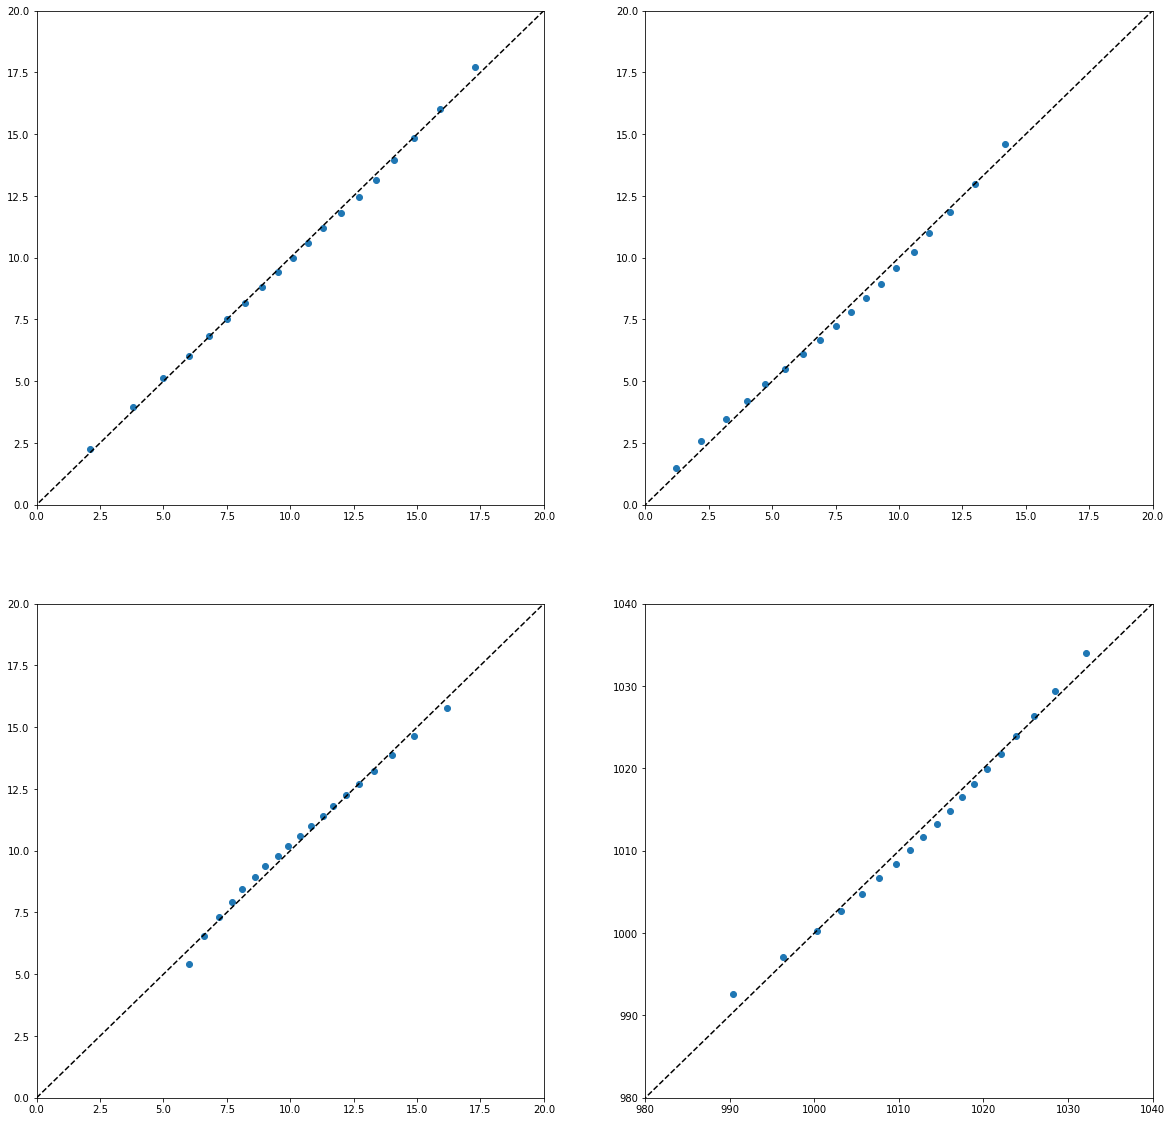

In [8]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Calculation of quantiles

def biplot(data, mle_data, axis, minx, maxx):
    percs = np.linspace(0, 100, 21)
    qn = np.percentile(data, percs)
    qn_norm= sts.norm.ppf(percs / 100.0, *mle_data)

    min_qn = np.min([data.min()])
    max_qn = np.max([data.max()])
    x = np.linspace(min_qn, max_qn)


    # Building a quantile biplot
    axis.plot(qn, qn_norm, ls="", marker="o", markersize=6)
    axis.plot(x, x, color="k", ls="--")
    axis.axis(xmin=minx,xmax=maxx)
    axis.axis(ymin=minx,ymax=maxx)

biplot(temp, mle_temp, axis[0, 0], 0, 20)
biplot(vappr, mle_vappr, axis[1, 0], 0, 20)
biplot(dewpt, mle_dewpt, axis[0, 1], 0, 20)
biplot(msl, mle_msl, axis[1, 1], 980, 1040)

plt.show()


Step 7. We estimate correctness of fitted distributions using 2 statistical tests.

In [9]:
def makeTests(data, name):
    dataHead = data.head(200)
    params = scipy.stats.norm.fit(dataHead)
    ks = scipy.stats.kstest(dataHead, 'norm', params)
    normaltest = scipy.stats.normaltest(dataHead)
    print(name)
    print(f"kstest {ks}")
    print(f"normaltest {normaltest}")
    print()

# 'temp','vappr','dewpt','msl'
makeTests(temp, 'temp')
makeTests(vappr, 'vappr')
makeTests(dewpt, 'dewpt')
makeTests(msl, 'msl')

temp
kstest KstestResult(statistic=0.047933129700474086, pvalue=0.7290694092881075)
normaltest NormaltestResult(statistic=0.5988758756559519, pvalue=0.7412347236192172)

vappr
kstest KstestResult(statistic=0.08624540452886875, pvalue=0.09618505617936657)
normaltest NormaltestResult(statistic=8.11861105647445, pvalue=0.017261002232544096)

dewpt
kstest KstestResult(statistic=0.06755832041869392, pvalue=0.30697368871049047)
normaltest NormaltestResult(statistic=1.513782162379219, pvalue=0.4691226263917606)

msl
kstest KstestResult(statistic=0.15172372592124334, pvalue=0.00017442074109472633)
normaltest NormaltestResult(statistic=97.11981210302885, pvalue=8.141431254542497e-22)

